Copyright (c) 2020 Ryan Cohn and Elizabeth Holm. All rights reserved. <br />
Licensed under the MIT License (see LICENSE for details) <br />
Written by Ryan Cohn

# Instance segmentation performance evaluation and sample characterization

In this example we will do the following:

  * Evaluate how well the predicted masks agree with the hand-drawn annotations
  * Perform basic sample measurements (ie particle size)
  * Match satellites to particles to measure the satellite content of samples
 
 
## Note: 
We lump the predictions on training images with the validation images. This is because our available data so far is very limited, so we just 
want to show the process for analyzing the results. The process is exactly the same for analyzing larger quantities of data, so after generating predictions
you can replace the filepath with more validation or even unlabeled images to get a better representation of the performance of the model.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import pandas as pd
import pickle
import pycocotools.mask as RLE
import seaborn as sns
import skimage
import skimage.io
from IPython.display import display
from math import pi

ampis_root = str(Path('..','..','..'))
import sys
if ampis_root not in sys.path:
    sys.path.append(ampis_root)

from ampis import analyze, data_utils, powder_char
from ampis.applications import powder
from ampis.structures import InstanceSet
from ampis.visualize import display_iset
from ampis import export_anno
from imantics import Polygons, Mask
#import warnings
#warnings.filterwarnings('error')

%matplotlib inline

# Loading Data
For evaluating the segmentation performance, we need to load back the original ground truth labels.

You can use your own predictions generated from before by replacing the paths, but as an example I am including mine from the fully trained model.

In [2]:
## load predicted labels

particles_path = Path('..','data','mass_particle_metrics.pickle')
assert particles_path.is_file()

satellites_path = Path('..','data','mass_satellite_metrics.pickle')
assert satellites_path.is_file()

with open(particles_path, 'rb') as f:
    particle_pred = pickle.load(f)

with open(satellites_path, 'rb') as f:
    satellites_pred = pickle.load(f)
#print(satellites_pred)
#x = powder_char.clean_pred_pickle_masks(satellites_pred)   

### Currently not being used because of a problem with local/global variables and Instance Objects

In [3]:
def clean_pred_instance(pred, instance_num):
    data_instance = pred
    removed_index_list = []
    for i in range(len(data_instance['instances'].pred_masks)):
        #intermediary step to convert each RLE instance to a binary mask
        m1 = RLE.decode(data_instance['instances'].pred_masks[i])[:, :]
        m2 = Mask(m1).polygons().points
        try:
            num_points = len(export_anno.split_array(m2[0])[0])
        except:
            print("Error: No points found, deleting annotation")
            num_points = 0
        if num_points < 4:
            removed_index_list.append(i)
    if len(removed_index_list) < 1:
        print('No Removals Required for instance', instance_num)
    else:
        print("Had to remove", len(removed_index_list), 'predicitons from the predicted detections on instance', instance_num)
    for i in range(len(removed_index_list)):
        data_instance['instances'].pred_masks.pop(removed_index_list[i]-i)
        np.delete(data_instance['instances'].pred_boxes, removed_index_list[i]-i)
        data_instance['instances'].num_instances -= 1
    return data_instance

        
def clean_pred_pickle_masks(pred):
    temp_pred = pred
    #for i in range(len(pred)):
    for i in range(10):
        temp_pred[i]['pred'] = clean_pred_instance(pred[i]['pred'], i)
    return temp_pred
#print(satellites_pred)
#satellites_pred = clean_pred_pickle_masks(satellites_pred)
#particle_pred = clean_pred_pickle_masks(particle_pred)

## Load data to InstanceSet objects
To standardize the format of the ground truth and predicted instances, and for convenient analysis, everything is loaded into an InstanceSet class object.

In [4]:
# Predicted instance sets
iset_particles_pred = [InstanceSet().read_from_model_out(x, inplace=False) for x in particle_pred]
iset_satellites_pred = [InstanceSet().read_from_model_out(x, inplace=False) for x in satellites_pred]

# Powder Characterization- Size Distribution

Once we have the masks it is pretty trivial to compute various properties. With binary masks we can use [skimage regionprops] (https://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops), which provides many convenient measurements out of the box. If there are any additional measurements you need, you can also access the masks directly and define your own methods. 

In [5]:
k = ['area', 'equivalent_diameter', 'major_axis_length', 'minor_axis_length', 'perimeter', 'eccentricity']
for iset in iset_satellites_pred:
    if iset.rprops is None:
        iset.compute_rprops(keys=k)
for iset in iset_particles_pred:
    if iset.rprops is None:
        iset.compute_rprops(keys=k)

## Powder Characterization Dataframes
If you wish to see the dataframes for all the images loaded in, uncomment the lines below

In [27]:
#for i in range(len(iset_satellites_pred)):
#    display(iset_satellites_pred[i].rprops)

Note that the measurements are in terms of pixels. If the conversion for pixels to microns is known, then we can generate equivalent measurements.

# Satellite content measurements
The process here is fairly straightforward. We have masks for powder particles and masks for satellites. To match the satellites to their corresponding particles, we simply overlay the masks and look for intersections. Then, it is trivial to count the number of particles containing satellites. 



We have more labeled satellite images than particle images. We only want to keep images that have labels for both particles and satellites.
To help with the implementation, we can combine the masks for particles and satellites in the PowderSatelliteImage class

### Warning:
You may encounter "RuntimeWarning: invalid value encountered in true_divide
  intersects = RLE.area([RLE.merge([satellite_mask, pmask], intersect=True) for pmask in particles])"
 This is ok. It is become some of the annotations have only 2 points and the area cannot be computed. The code should ignore these and continue on with the rest

In [6]:
iset_particles_pred_ss, iset_satellites_pred_ss = analyze.align_instance_sets(iset_particles_pred, iset_satellites_pred)
psi_pred = []
for pp, sp in zip(iset_particles_pred_ss, iset_satellites_pred_ss):
    files = [Path(x).name for x in [pp.filepath, sp.filepath]]
    assert all([x == files[0] for x in files])  # the files are in the same order and there are no excess files
    psi_pred.append(powder.PowderSatelliteImage(particles=pp, satellites=sp))
for i in range(len(psi_pred)):
    try:
        psi_pred[i].compute_matches()
    except:
        print(i)

/jet/home/sprice/AMPIS/ampis/applications/powder.py:82: RuntimeWarning: invalid value encountered in true_divide
  intersects = RLE.area([RLE.merge([satellite_mask, pmask], intersect=True) for pmask in particles]) \


# Computing Powder Characteristics
This takes all of the satellite and particle mask data and computes mean statistics. 

In [7]:
'''data = {'mean_sat_eccentricty': [], 'mean_sat_area': [], 'mean_sat_perimeter': [],
        'mean_par_eccentricty': [], 'mean_par_area': [], 'mean_par_perimeter': []}
        
for i in range(len(psi_pred)):
    data['mean_sat_eccentricty'].append(float("{0:.4f}".format(psi_pred[i].satellites.rprops.eccentricity.mean()[0])))
    data['mean_sat_area'].append(float("{0:.4f}".format(psi_pred[i].satellites.rprops.area.mean()[0])))
    data['mean_sat_perimeter'].append(float("{0:.4f}".format(psi_pred[i].satellites.rprops.perimeter.mean()[0])))
    data['mean_par_eccentricty'].append(float("{0:.4f}".format(psi_pred[i].particles.rprops.eccentricity.mean()[0])))
    data['mean_par_area'].append(float("{0:.4f}".format(psi_pred[i].particles.rprops.area.mean()[0])))
    data['mean_par_perimeter'].append(float("{0:.4f}".format(psi_pred[i].particles.rprops.perimeter.mean()[0])))
print('Mean_Sat_Eccentricity ', data['mean_sat_eccentricty'], '\nMean_sat_area: ', data['mean_sat_area'], '\nMean_sat_perimeter: ', data['mean_sat_perimeter'])
print('Mean_Par_Eccentricity ', data['mean_par_eccentricty'], '\nMean_par_area: ', data['mean_par_area'], '\nMean_par_perimeter: ', data['mean_par_perimeter'])
'''
print('')

# Computing/Graphing Satellite Area Ratio Distributio

In [8]:
sat_area_ratio = []
outliers = []
total_sat_area_ratio = []
par_eccentricity = []
sat_eccentricity = []
for i in psi_pred:
    for j in i.matches['match_pairs']:
        sats_area = []
        par_eccentricity.append(i.particles.rprops.iloc[j]['eccentricity'][0])
        for k in i.matches['match_pairs'][j]:
            sat_eccentricity.append(i.satellites.rprops.iloc[k]['eccentricity'][0])
            if i.satellites.rprops.iloc[k]['area']/i.particles.rprops.iloc[j]['area'] < 2:
                sat_area_ratio.append((i.satellites.rprops.iloc[k]['area']/i.particles.rprops.iloc[j]['area'])[0])
                sats_area.append(i.satellites.rprops.iloc[k]['area'][0])
            else:
                outliers.append((i.satellites.rprops.iloc[k]['area']/i.particles.rprops.iloc[j]['area'])[0])
        total_sat_area_ratio.append((sum(sats_area)/i.particles.rprops.iloc[j]['area'])[0])



sat_area_average = (sum(sat_area_ratio)/len(sat_area_ratio))
#sat_outlier_average = (sum(outliers)/len(outliers))[0]
total_sat_area_average = (sum(total_sat_area_ratio)/len(total_sat_area_ratio))
sat_eccentricity_average = (sum(sat_eccentricity)/len(sat_eccentricity))
par_eccentricity_average = (sum(par_eccentricity)/len(par_eccentricity))

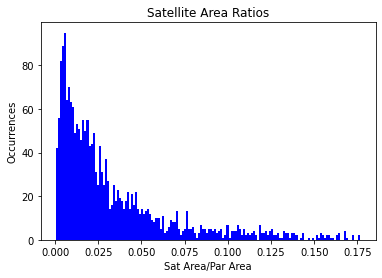

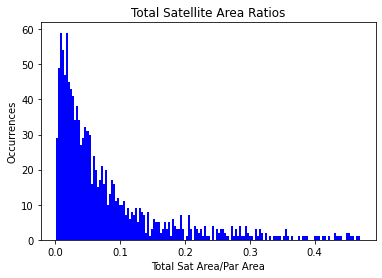

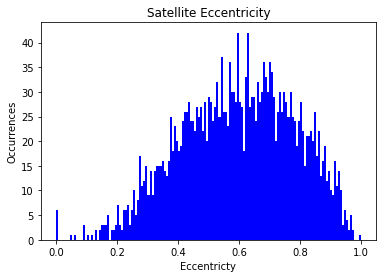

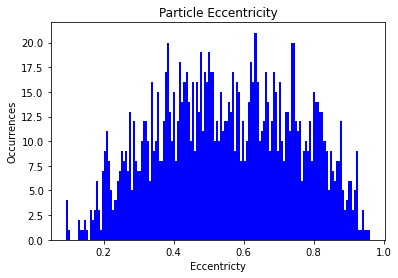

In [9]:
powder_char.generate_histogram(powder_char.sort_and_clean(sat_area_ratio), 150, 'Satellite Area Ratios', 'Sat Area/Par Area', 'Occurrences')
powder_char.generate_histogram(powder_char.sort_and_clean(total_sat_area_ratio), 150, 'Total Satellite Area Ratios', 'Total Sat Area/Par Area', 'Occurrences')
powder_char.generate_histogram(powder_char.sort_and_clean(sat_eccentricity), 150, 'Satellite Eccentricity', 'Eccentricty', 'Occurrences')
powder_char.generate_histogram(powder_char.sort_and_clean(par_eccentricity), 150, 'Particle Eccentricity', 'Eccentricty', 'Occurrences')

The matches for psi are stored in psi.matches as a dictionary. The key 'match_pairs' returns a dictionary whose keys are indices of particle masks that contain satellites. The value corresponding to each key is a list of indices of satellite masks that matched (note that multiple satellites can match with a single particle.)

To compute the ratio of satellited particles, we can get the total number of 

## Final satellite measurements

The number of satellites in each set, fraction of satellited particles, and some other information can be displayed with one command.
The results can be printed directly, and are also returned

In [32]:
print('predicted results')
results_pred = powder.satellite_measurements(psi_pred, True, True)
print('Mean Satellite Area Ratio: \t\t', sat_area_average)
#print('Mean of Satellite Area Ratios \ngreater than 1 (outlier):\t\t', len(outliers))
print('Mean Total Satellite Area Ratio: \t', total_sat_area_average)
print('Mean Sat_Eccentricity(Sphericalness): \t', sat_eccentricity_average)
print('Mean Par_Eccentricity(Sphericalness): \t', par_eccentricity_average)

predicted results
number of images                   	33
number of particles                	3905
number of matched satellites       	2429
number of unmatched satellites     	439
number of satellited particles     	1465
fraction of satellited particles   	0.37516005121638923
median number of satellites per
satellited particle             	1.0
Mean Satellite Area Ratio: 		 0.13272852865833418
Mean Total Satellite Area Ratio: 	 0.2200666185058657
Mean Sat_Eccentricity(Sphericalness): 	 0.5967209764764511
Mean Par_Eccentricity(Sphericalness): 	 0.5534526666185682


The results are (optionally) returned as a dictionary in case you need to store them for further analysis or post processing.

In [22]:
results_gt

{'n_images': 5,
 'n_particles': 1360,
 'n_satellites': 585,
 'n_satellites_unmatched': 2,
 'n_satellited_particels': 315,
 'sat_frac': 0.23161764705882354,
 'mspp': 1.0,
 'unique_satellites_per_particle': array([ 1,  2,  3,  4,  5,  6,  7, 14]),
 'counts_satellites_per_particle': array([0.53333333, 0.79047619, 0.9047619 , 0.96507937, 0.98095238,
        0.99047619, 0.9968254 , 1.        ])}